In [1]:
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:
import tikzplotlib
import sys
#from live_wdd.parameters import physical_coordinate, est_scale
from libertem.common import Shape 
from scipy.ndimage import center_of_mass 
from live_wdd.dim_reduct import get_sampled_basis, compress, decompress
from live_wdd.live_wdd import prepare_livewdd
from live_wdd.wdd_udf import WDDUDF
from perf_utils import timer
import time
import numpy as np
import scipy

In [3]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
from libertem.udf.sum import SumUDF
from libertem.udf.sumsigudf import SumSigUDF

In [5]:
from libertem.api import Context
from libertem.corrections.coordinates import rotate_deg, flip_y

In [6]:

import numpy as np
import multiprocessing


In [7]:
from libertem.api import Context

In [8]:
dim = (128,128,256,256)

In [9]:
path = '/cachedata/users/clausen/Ptycho01/20200518 165148/default.hdr'
 
# Create context
ctx = Context()

ds = ctx.load("auto", path=path, nav_shape=(dim[0], dim[1]), sig_shape=(dim[2], dim[3]))  
ds.set_num_cores(4*18)


In [10]:
sum_udf = ctx.run_udf(dataset=ds, udf=SumUDF(), progress=False)['intensity'].data

In [11]:
com=scipy.ndimage.center_of_mass(sum_udf)

In [12]:
com

(126.65307795083199, 123.70109927061029)

<IPython.core.display.Javascript object>


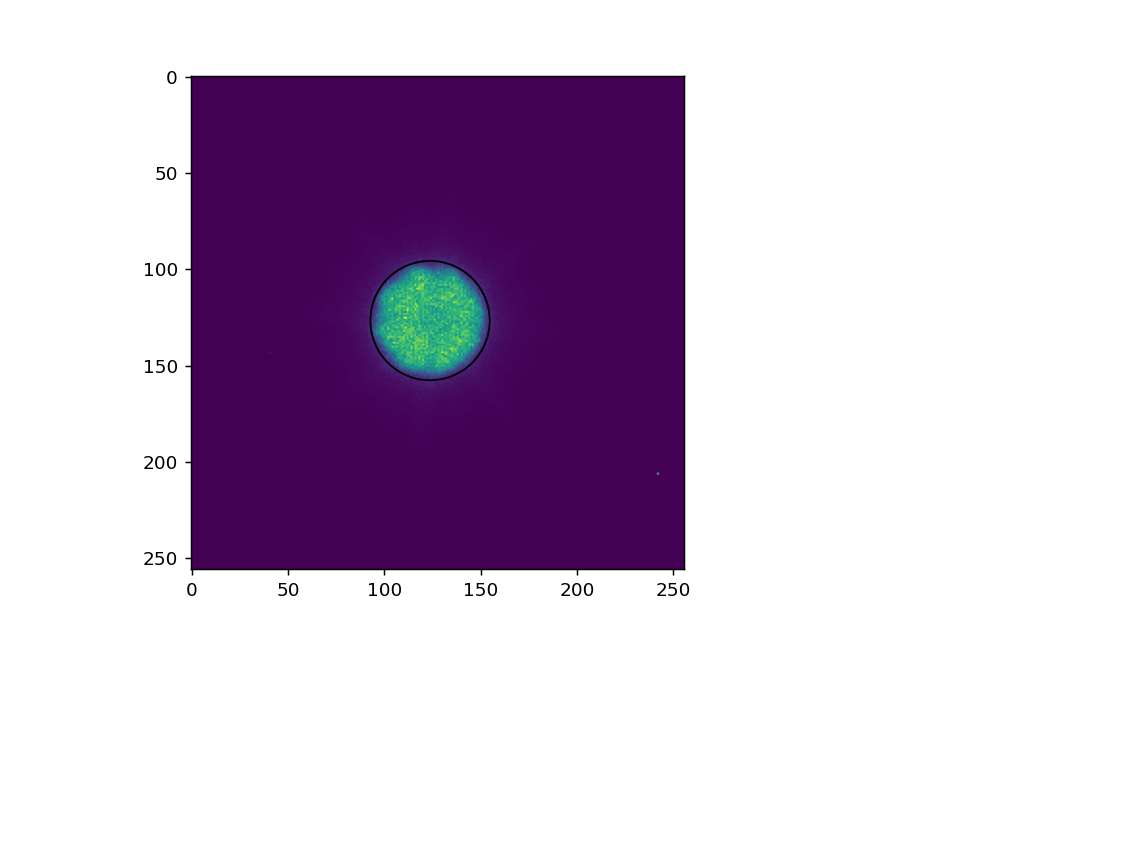

In [13]:
rad = 15.5*2
fig, ax = plt.subplots()
ax.imshow(sum_udf)
circ_a = plt.Circle(np.flip(com),rad, fill=False)
ax.add_artist(circ_a)

## Check Dark Field to get reference coordinate

In [14]:
df = ctx.create_ring_analysis(dataset=ds,
                              cx=com[1], cy=com[0],
                              ri=rad, ro = rad +5)

In [17]:
df_array = ctx.run(df)['intensity']

<IPython.core.display.Javascript object>


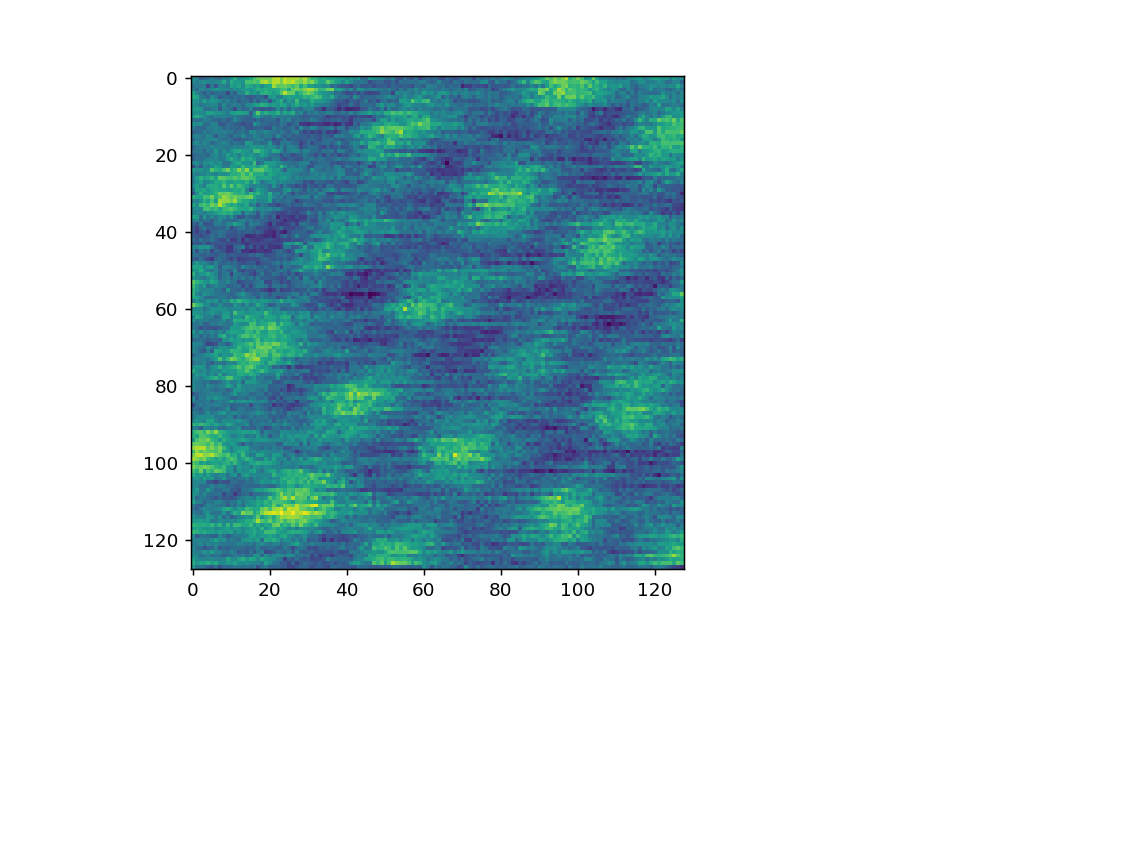

In [18]:
fig, ax = plt.subplots()
ax.imshow(df_array)

# Reconstruction Parameters

In [19]:
acc = 300# in kV
scan_real = 0.0127 # in nm
semiconv= 22.13 # In mrad
rad = 15.5*2
order = 16
com = com
complex_dtype=np.complex64

In [20]:
transformation = rotate_deg(88) @ flip_y()

# Pre-computed Wiener

In [21]:
scan_idx, wiener_filter_compressed,row_exp, col_exp,coeff = prepare_livewdd(ds.shape, acc, scan_real, 
                                                                            semiconv, rad, com, order,
                                                                            complex_dtype,
                                                                            ctx, ds, transformation)

timer pre computing Wiener 24.83582s


## Map to lower dimensional and back

<IPython.core.display.Javascript object>


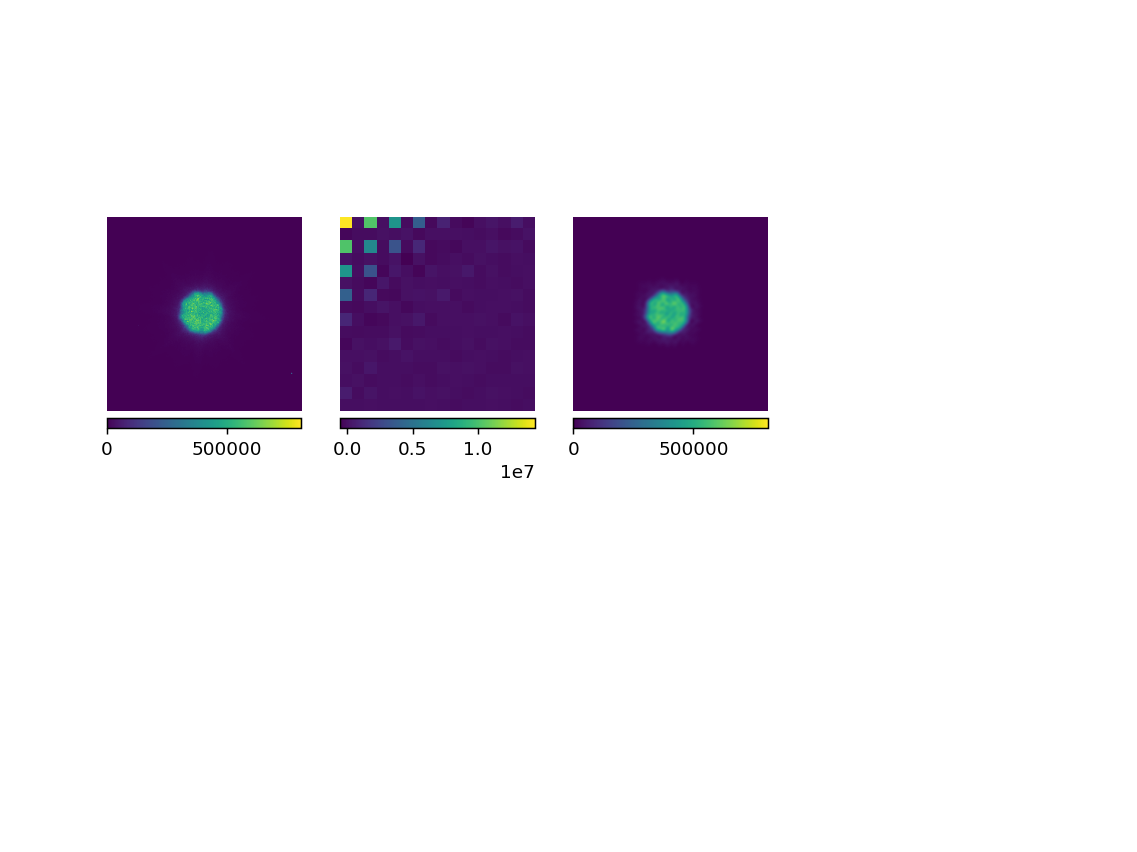

In [23]:
idp_compress = compress(sum_udf, coeff)
idp_decompress = decompress(idp_compress, coeff)
fig, (ax1,ax2, ax3) = plt.subplots(1,3)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('bottom', size='5%', pad=0.05)


im1=ax1.imshow(sum_udf, vmin=np.min(sum_udf), vmax = np.max(sum_udf))
im2=ax2.imshow(idp_compress)
im3=ax3.imshow(idp_decompress, vmin=np.min(sum_udf), vmax=np.max(sum_udf))
 
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
fig.colorbar(im1, cax=cax1, orientation='horizontal') 
fig.colorbar(im2, cax=cax2, orientation='horizontal') 
fig.colorbar(im3, cax=cax3, orientation='horizontal') 

## Live WDD Reconstruction

In [24]:
%%time
complex_dtype = np.complex64
live_wdd = ctx.run_udf(dataset=ds, roi = None, 
                       udf= WDDUDF(wiener_filter_compressed, scan_idx, coeff, row_exp, col_exp, complex_dtype))

live_wdd_recon = live_wdd['reconstructed']


CPU times: user 1.37 s, sys: 259 ms, total: 1.63 s
Wall time: 5.43 s


<IPython.core.display.Javascript object>


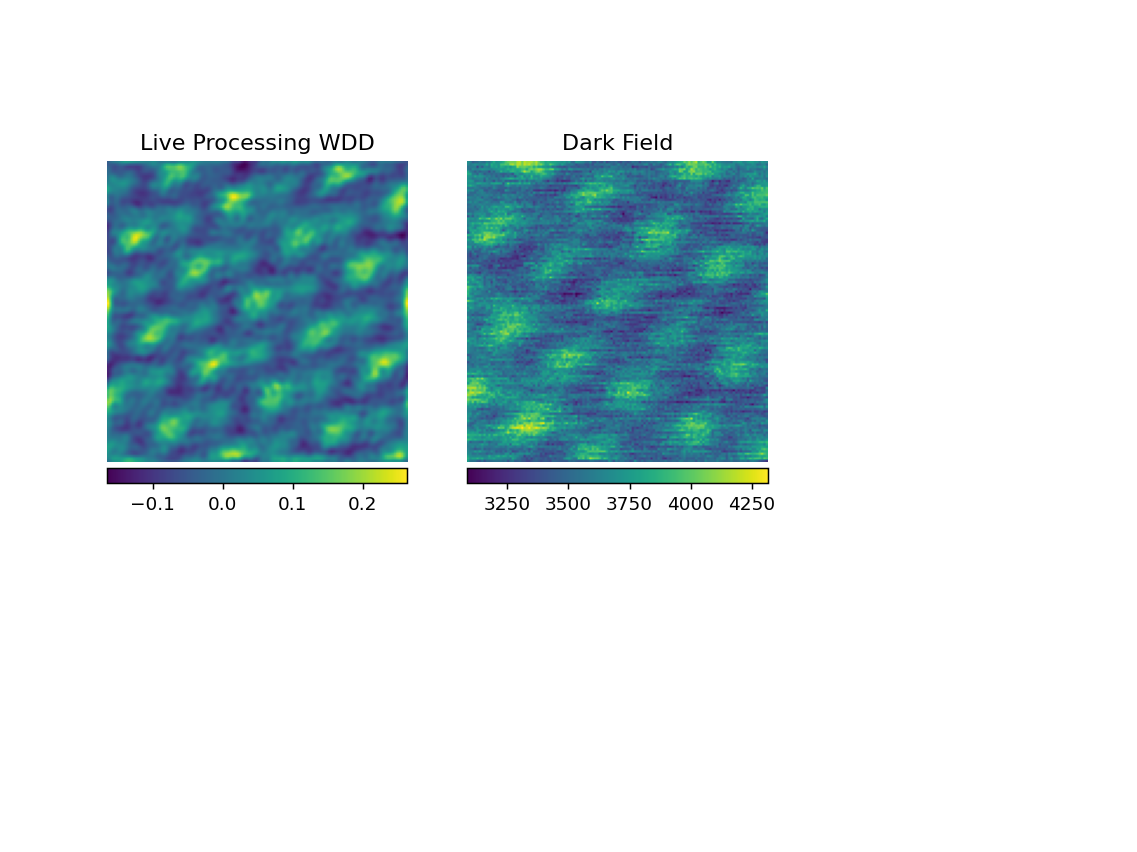

In [28]:

fig,(ax1,ax2) = plt.subplots(1,2)
#fig.tight_layout()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
im1 = ax1.imshow(np.angle(live_wdd_recon))
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('bottom', size='5%', pad=0.05)
im2 = ax2.imshow(df_array)
ax2.set_axis_off()
ax2.set_title('Dark Field')
ax1.set_axis_off()
ax1.set_title('Live Processing WDD')
fig.colorbar(im1, cax=cax1, orientation='horizontal') 
fig.colorbar(im2, cax=cax2, orientation='horizontal') 

In [29]:
%%time
dd = []
dam = []
complex_dtype = np.complex64
for udf_results in ctx.run_udf_iter(dataset=ds, roi = None, 
                       udf= WDDUDF(wiener_filter_compressed, scan_idx, coeff, row_exp, col_exp, complex_dtype)):
    dd.append(np.copy(udf_results.buffers[0]['reconstructed'].data))
    dam.append(np.copy(udf_results.damage.data))

CPU times: user 1.14 s, sys: 226 ms, total: 1.36 s
Wall time: 4.21 s


<IPython.core.display.Javascript object>


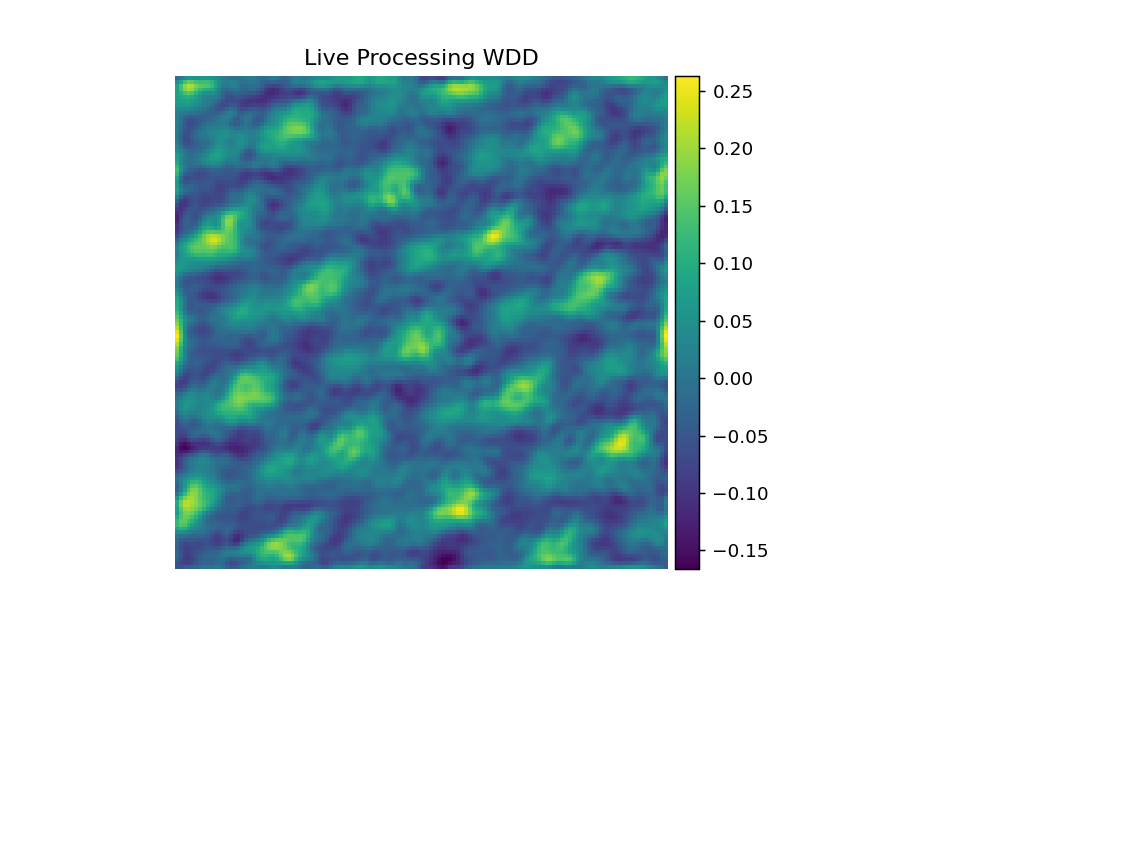

In [30]:

fig,ax = plt.subplots()
#fig.tight_layout()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(np.angle(np.fliplr(np.flipud(live_wdd_recon))))
ax.set_axis_off()
ax.set_title('Live Processing WDD')
fig.colorbar(im, cax=cax, orientation='vertical') 

In [31]:

idx_buffer = np.ceil(np.linspace(10,len(dam)-1,5)).astype(int)


In [32]:
 idx_buffer

array([10, 26, 41, 57, 72])

<IPython.core.display.Javascript object>


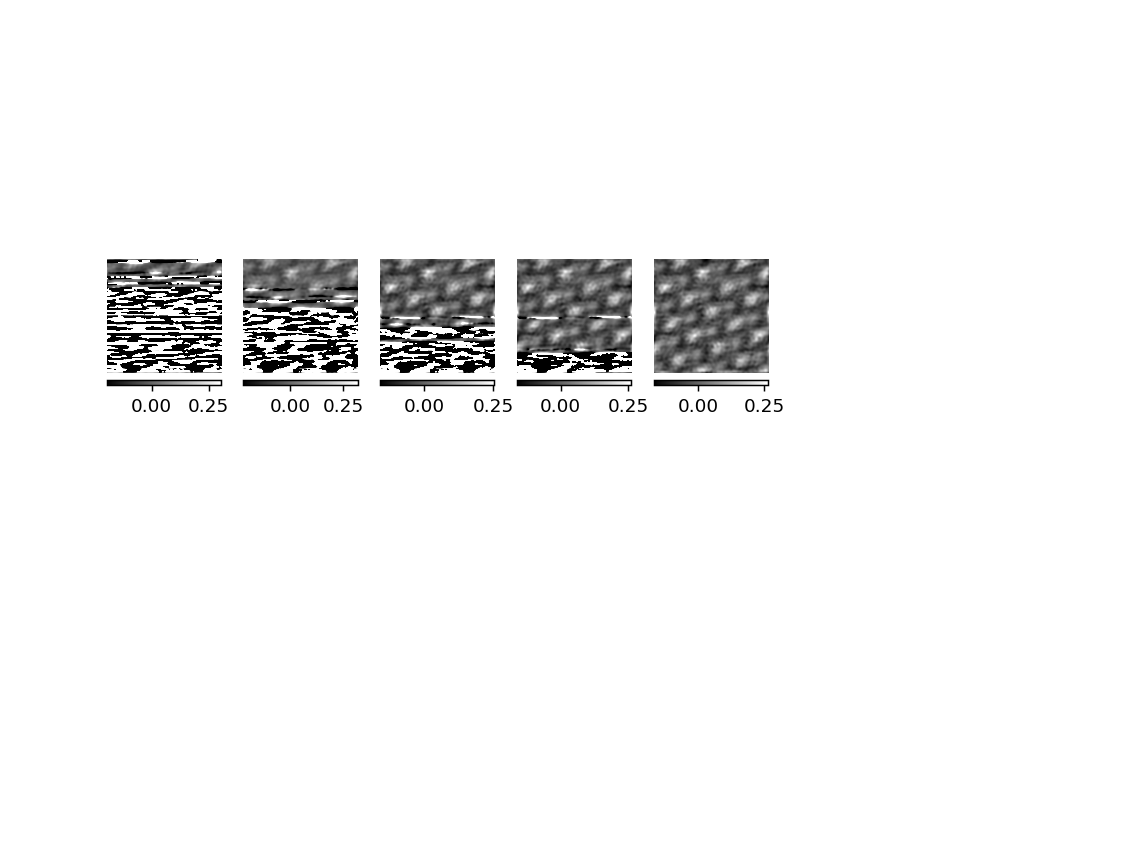

In [33]:
fig, ax = plt.subplots(1,len(idx_buffer), constrained_layout=False)

for id_buff in range(len(idx_buffer)):
    divider = make_axes_locatable(ax[id_buff])
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    idx_show = idx_buffer[id_buff]
    
    vmin = np.min(np.angle(dd[idx_show])[dam[idx_show]])
    vmax = np.max(np.angle(dd[idx_show])[dam[idx_show]])
    im = ax[id_buff].imshow(np.angle(dd[idx_show]), vmin=vmin,vmax=vmax,cmap = 'gray')
    ax[id_buff].set_axis_off()
    fig.colorbar(im, cax=cax, orientation='horizontal')